# Is Seattle Really Seeing an Uptick in Cycling?

*This notebook originally appeared as a [post](http://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is BSD licensed.*

*Update: as I was putting the finishing touches on this notebook, I noticed [this post](http://www.seattlebikeblog.com/2014/06/09/a-statistical-analysis-of-biking-on-the-fremont-bridge-part-1-overview/), the first in a series on Seattle Bike Blog which analyzes much of the same data used here. Apparently great minds think alike! (incidentally, to prove that I'm not just cribbing that content, check the [github commit log](http://github.com/jakevdp/SeattleBike/commits/master): I wrote the bulk of this post several days before the SBB blog series was posted. Version control priority FTW!)*

*Update #2: I added error bars to the estimates in the final section (should have done that from the beginning, I know...*

<!-- PELICAN_BEGIN_SUMMARY -->
Cycling in Seattle seems to be taking off. This can be seen qualitatively in the increased visibility of advocacy groups like [Seattle Neighborhood Greenways](http://seattlegreenways.org/) and [Cascade Bicycle Club](http://www.cascade.org/), the excellent reporting of sites like the [Seattle Bike Blog](http://www.seattlebikeblog.com/), and the investment by the city in high-profile traffic safety projects such as [Protected Bike Lanes](http://www.seattle.gov/transportation/PBL.htm), [Road diets/Rechannelizations](http://www.seattle.gov/transportation/pedestrian_masterplan/pedestrian_toolbox/tools_deua_diets.htm) and the [Seattle Bicycle Master Plan](http://www.seattle.gov/transportation/bikemaster.htm).

But, qualitative arguments aside, there is also an increasing array of quantitative data available, primarily from the [Bicycle counters](http://www.seattle.gov/transportation/bikecounter.htm) installed at key locations around the city. The first was the [Fremont Bridge Bicycle Counter](http://www.seattle.gov/transportation/bikecounter_fremont.htm), installed in October 2012, which gives daily updates on the number of bicycles crossing the bridge: currently upwards of 5000-6000 per day during sunny commute days.

Bicycle advocates have been [pointing out](http://www.seattlebikeblog.com/2014/05/14/fremont-bridge-smashes-bike-count-record-for-real-this-time-bike-use-rises-all-over-town/) the upward trend of the counter, and I must admit I've been excited as anyone else to see this surge in popularity of cycling (Most days, I bicycle 22 miles round trip, crossing both the Spokane St. and Fremont bridge each way).

But anyone who looks closely at the data must admit: there is a large weekly and monthly swing in the bicycle counts, and people seem most willing to ride on dry, sunny summer days. Given the warm streak we've had in Seattle this spring, I wondered: **are we really seeing an increase in cycling, or can it just be attributed to good weather?**

<!-- PELICAN_END_SUMMARY -->

Here I've set-out to try and answer this question. Along the way, we'll try to deduce just how much the weather conditions affect Seattleites' transportation choices.

## A Quick Aside

If anyone is landing on this page via the normal bicycle advocacy channels, I should warn you that this won't look like a typical Seattle-bike-advocate blog post. I currently work as a data scientist at the [University of Washington eScience Institute](http://data.washington.edu/), where I'm incredibly fortunate to have the flexibility to spend a couple hours each week on side-projects like this. Most of my [blog posts](http://jakevdp.github.io) are pretty technical in nature: I tend to focus on statistical methods and visualization using the [Python](http://www.python.org) programming language.

This post is composed in an [IPython notebook](http://ipython.org/notebook.html), which is a fully executable document which combines text, data, code, and visualizations all in one place. The nice thing is that anyone with a bit of desire and initiative could install the (free) IPython software on their computer and open this document, re-running and checking my results, and perhaps modifying my assumptions to see what happens. In a way, this post is as much about **how** to work with data as it is about **what** we learn from the data.

In other words, this is an **entirely reproducible analysis**. Every piece of data and software used here is open and freely available to anyone who wants to use it. It's an example of the direction I think data journalism should go as it starts to more and more emulate data-driven scientific research.

That said, there's a lot of technical stuff below. If you're not familiar with Python or other data analysis frameworks, don't be afraid to skip over the code and look at the plots, which I'll do my best to explain.

## The Data

This post will use two datasets, which you can easily access with an internet connection. You can find the exact data I used in the [GitHub repository](https://github.com/jakevdp/SeattleBike), or access it from the original sources below.

First, I'll be using the Fremont Bridge Hourly Bicycle Counts. To download this data, go to the [fremont bridge](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k) page, and do the following (I accessed this on June 6th, 2014):

- click "export"
- click "download as CSV"

Second, I'll be using weather data available at the [National Climatic Data Center](http://www.ncdc.noaa.gov/). We'll use weather data from the SeaTac Airport weather station. To get this data, go to the [Climate Data Search](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) page and do the following (I accessed this on June 6th, 2014):

- Choose "Daily Summaries"
- Choose 2012/10/1 to the present date
- Search for "Station", and type in "USW00024233" (ID for SeaTac Airport weather station)
- Click the icon on the map and "Add to Cart"
- go to "Shopping Cart"
  
  - make sure date range is 2012/10/1 to 2014/5/14
  - choose Custom GHCN-Daily CSV
  - click "Continue"
  
- next page: click "select all"
- click "continue"
- enter email address and submit order

When the data set is ready, you will get an email with a download link. It was about an hour wait when I did it.

## Examining the Fremont Bridge Data

The first thing we're going to do is load and examine the data from the Fremont bike counter. We'll use the [pandas](http://pandas.pydata.org/) package, a free and open source set of data analysis tools for the Python language.

In [1]:
# some necessary imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# Load the data file, and create a column with total north/south traffic

hourly = pd.read_csv("../DATA/FremontBridge.csv", index_col='Date', parse_dates=True)
hourly.columns = ['northbound', 'southbound']
hourly['total'] = hourly['northbound'] + hourly['southbound']
hourly.head()

,northbound,southbound,total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


In [32]:
# Resample the data into daily and weekly totals

# daily = hourly.resample('d', 'sum')
# weekly = daily.resample('w', 'sum')
daily = hourly.resample('d').sum()  # updated 9/12/2017 JMS
weekly = daily.resample('w').sum()
daily.head()
weekly.head()

,northbound,southbound,total
Date,,,
2012-10-07,7297.0,6995.0,14292.0
2012-10-14,8679.0,8116.0,16795.0
2012-10-21,7946.0,7563.0,15509.0
2012-10-28,6901.0,6536.0,13437.0
2012-11-04,6408.0,5786.0,12194.0


Now let's take a peek at our data and see what it looks like:

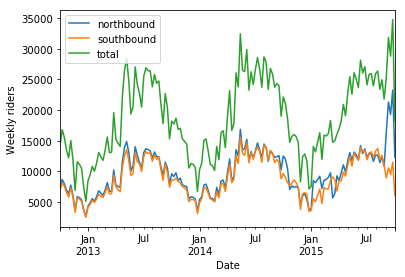

In [33]:
weekly[['northbound', 'southbound', 'total']].plot()
plt.ylabel('Weekly riders');

The red line shows the total number of weekly crossings, which is the sum of the northbound and southbound crossings.

At first glance, April and May 2014 include some spikes in the data: over 32,000 riders per week crossed the bridge one week in May! This trend might be a bit clearer if we use a **moving window average**: basically, for each day we'll take the average of the 30-day period around it:

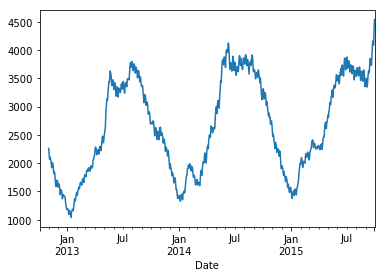

In [34]:
# pd.stats.moments.rolling_mean(daily['total'], 30).plot();
daily['total'].rolling(window=30,center=False).mean().plot()  # updated 9/12/2017 by JMS

This is the increased ridership that folks have been talking about. There is some seasonal variation, but the trend seems clear: 2014 has seen a lot of cyclists crossing the bridge.

But it is clear that there is still some seasonal variation. What we're going to try to do below is to **model this variation** based on our intuition about what factors might come into play in people's decision about whether to ride.

For simplicity, I'm going to stick with a **linear model** here. It would be possible to go deeper and use a more sophisticated model (I'd eventually like to try Random Forests), but a linear model should give us a good approximation of what's happening.

## Step 1: Accounting for hours of daylight

The largest component of the variation we see is a seasonal swing. I'm going to hypothesize that that swing is at least partially due to the changing daylight hours. We'll compute the number of hours of daylight and use this to de-trend the data.

Fortunately, my PhD is in Astronomy, so I once-upon-a-time learned how to compute this:

In [35]:
# Define a function which returns the hours of daylight
# given the day of the year, from 0 to 365

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

# add this to our weekly data
weekly['daylight'] = list(map(hours_of_daylight, weekly.index))
daily['daylight'] = list(map(hours_of_daylight, daily.index))
weekly.head()

,northbound,southbound,total,daylight
Date,,,,
2012-10-07,7297.0,6995.0,14292.0,11.045208
2012-10-14,8679.0,8116.0,16795.0,10.644852
2012-10-21,7946.0,7563.0,15509.0,10.255305
2012-10-28,6901.0,6536.0,13437.0,9.881095
2012-11-04,6408.0,5786.0,12194.0,9.527645


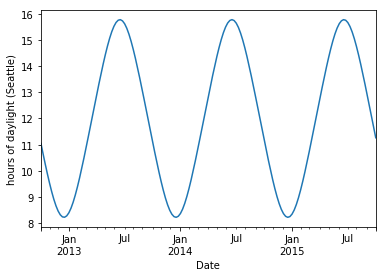

In [36]:
# Plot the daylight curve

weekly['daylight'].plot()
plt.ylabel('hours of daylight (Seattle)');

This looks reasonable: just over 8 hours of daylight in December, and just under 16 hours in June.

To get a feel for the trend, let's plot the daylight hours versus the weekly bicycle traffic:

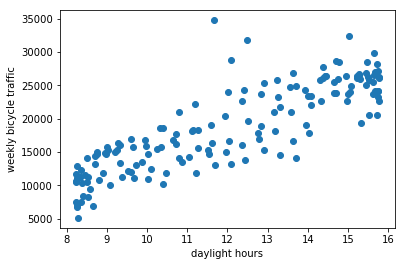

In [37]:
plt.scatter(weekly['daylight'], weekly['total'])
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

We see a clear trend, though it's also apparent from the wide vertical scatter that other effects are at play.

Let's apply a linear fit to this data. Basically, we'll draw a best-fit line to the points using some convenient tools in the [scikit-learn](http://scikit-learn.org) package, which I've been active in developing:

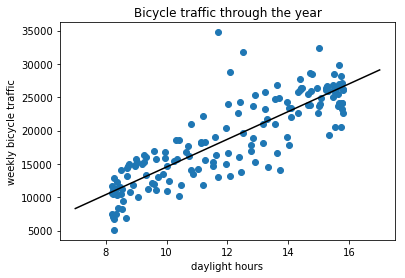

In [38]:
from sklearn.linear_model import LinearRegression

X = weekly[['daylight']].to_dense()
y = weekly['total']
clf = LinearRegression(fit_intercept=True).fit(X, y)

weekly['daylight_trend'] = clf.predict(X)
weekly['daylight_corrected_total'] = weekly['total'] - weekly['daylight_trend'] + weekly['daylight_trend'].mean()

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])
plt.scatter(weekly['daylight'], weekly['total'])
plt.plot(xfit, yfit, '-k')
plt.title("Bicycle traffic through the year")
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

Once such a linear model is fit, we can look at the model coefficients to see, on average, how the change in one variable affects the change in another:

In [39]:
print(clf.coef_[0])

2078.09203625


This tells us that according to this model, each extra hour of daylight leads to about 2000 more riders per week across the bridge! Of course, in Seattle the length of the day also correlates highly with temperature and precipitation; we'll try to untangle those effects later.

Now that we have fit this trend, let's subtract it off and replace it by the mean:

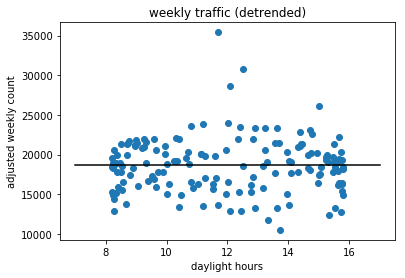

In [40]:
trend = clf.predict(weekly[['daylight']].as_matrix())
plt.scatter(weekly['daylight'], weekly['total'] - trend + np.mean(trend))
plt.plot(xfit, np.mean(trend) + 0 * yfit, '-k')
plt.title("weekly traffic (detrended)")
plt.xlabel('daylight hours')
plt.ylabel('adjusted weekly count');

This is what I mean by "de-trended" data. We've basically removed the component of the data which correlates with the number of hours in a day, so that what is left is in some way agnostic to this quantity. The "adjusted weekly count" plotted here can be thought of as the number of cyclists we'd expect to see if the hours of daylight were not a factor.

Let's visualize this another way. Instead of plotting the number of riders vs daylight hours, we'll again plot the number of riders vs the day of the year, along with the trend:

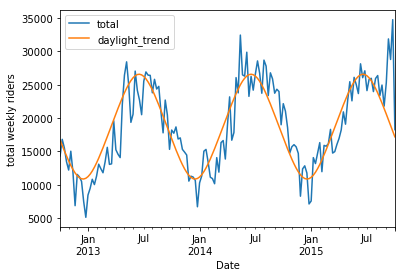

In [41]:
weekly[['total', 'daylight_trend']].plot()
plt.ylabel("total weekly riders");

We can similarly view the adjusted total number of riders over time by subtracting this green line from the blue line:

root-mean-square about trend: 3455 riders


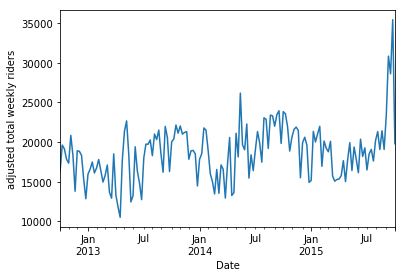

In [42]:
weekly['daylight_corrected_total'].plot()
rms = np.std(weekly['daylight_corrected_total'])
plt.ylabel("adjusted total weekly riders")
print("root-mean-square about trend: {0:.0f} riders".format(rms))

With the data de-trended, we get a better idea of how bicycling in Seattle has changed over time, corrected for the seasonal variation.

## Accounting for Day of the Week

Above we've been looking at weekly data. This is because daily data shows a clear swing as a function of the day of the week, which we'll show here.

In [43]:
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
daily['dayofweek'] = daily['total'].index.dayofweek

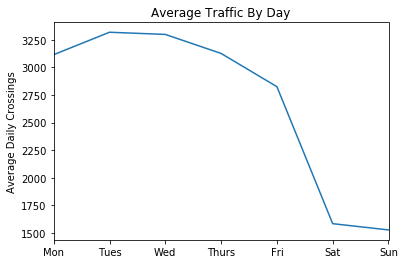

In [44]:
grouped = daily.groupby('dayofweek')['total'].mean()
grouped.index = days

grouped.plot()
plt.title("Average Traffic By Day")
plt.ylabel("Average Daily Crossings");

As you might expect in a city of bicycle commuters, there is roughly 2.5 times the amount of traffic on weekdays as there is on weekends. Bicycles are not just for entertainment! In Seattle, at least, they are a real means of commuting for thousands of people per day, and the data show this clearly.

Let's de-trend the daily bike counts based on the daily totals. We'll add a variable for each day of the week, and use each of these within the trend (this is an example of what's sometimes known as "one-hot" encoding).

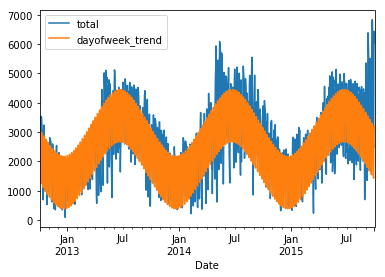

In [45]:
# Add one-hot indicators of weekday
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

# de-trend on days of the week and daylight together
X = daily[days + ['daylight']]
y = daily['total']
clf = LinearRegression().fit(X, y)

daily['dayofweek_trend'] = clf.predict(X)
daily[['total', 'dayofweek_trend']].plot();

This shows all the daily bicycle counts (in blue) along with the best-fit trend based on the day of the week and the number of daylight hours per day. It's more clear if we plot the de-trended data:

rms = 735


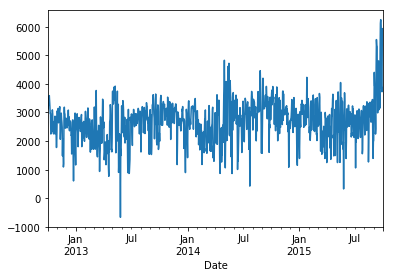

In [46]:
daily['dayofweek_corrected'] = (daily['total'] - daily['dayofweek_trend'] + daily['dayofweek_trend'].mean())
print("rms = {0:.0f}".format(np.std(daily['dayofweek_corrected'])))
daily['dayofweek_corrected'].plot();

Now we're getting somewhere! What we're seeing here is the number of bicycle crossings per day, corrected for the daily and annual trends.  In other words, this is what we might expect the data to look like if the day of the week and the hours of light per day did not matter.

Let's continue on this line of reasoning, and add some more information to the model.

## Accounting for Temperature and Precipitation

Next we'll account for the NCDC climate data that was described above.  The data includes the daily maximum and minimum temperatures, as well as the amount of recorded rainfall at SeaTac airport, about 15 miles to the south. Let's take a look at this data:

In [47]:
# Read the weather file
weather = pd.read_csv('SeaTacWeather.csv', index_col='DATE', parse_dates=True, usecols=[2, 3, 6, 7])

# temperatures are in 1/10 deg C; convert to F
weather['TMIN'] = 0.18 * weather['TMIN'] + 32
weather['TMAX'] = 0.18 * weather['TMAX'] + 32

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254

weather['TMIN'].resample('w', 'min').plot()
weather['TMAX'].resample('w', 'max').plot()
plt.ylabel('Weekly Temperature Extremes (F)');
plt.title("Temperature Extremes in Seattle");

FileNotFoundError: File b'SeaTacWeather.csv' does not exist

This shows the maximum and minimum temperatures in Seattle. They vary in ways you might expect. For example, you can easily see the late 2013 freeze that killed my artichoke plants last year.

Now let's look at precipitation:

In [ ]:
weather['PRCP'].resample('w', 'sum').plot();
plt.ylabel('Weekly precipitation (in)')
plt.title("Precipitation in Seattle");

The precipitation is also as you might expect. Almost none in the summer months, and up to about 4 inches per week in the rainiest parts of the year. 

What we do next will start to look very familiar: we'll add the climate information to our original daily dataset, and then use a linear model to de-trend the data with this new information.

In [ ]:
# join the weather data to our daily data
daily = daily.join(weather)

In [ ]:
columns = days + ['daylight', 'TMIN', 'TMAX', 'PRCP']

X = daily[columns]
y = daily['total']
clf = LinearRegression().fit(X, y)
daily['overall_trend'] = clf.predict(X)

# Plot the overall trend
daily[['total', 'overall_trend']].plot()
plt.ylabel('Daily bicycle traffic');

This shows the data along with the overall trend, accounting for precipitation and temperature extremes. Let's de-trend the data with this model and see what's left over:

In [ ]:
daily['overall_corrected'] = daily['total'] - daily['overall_trend'] + daily['overall_trend'].mean()
print("rms = {0:.0f}".format(np.std(daily['overall_corrected'])))
daily['overall_corrected'].plot()
plt.ylabel('corrected daily bicycle traffic');

From the reduced RMS, we can see that our model does a fairly good job capturing the trends. But there's still some daily variation that it cannot account for. We could think about what this might be, and try to capture it with more inputs to the model. For example, a person's choice to ride might be affected not just by the weather today, but by the weather yesterday. We also could account for freezing temperatures, which may manifest as a nonlinear effect.

In order to better see the remaining trend, let's plot a month-long moving-window average over the corrected data:

In [ ]:
pd.stats.moments.rolling_mean(daily['overall_corrected'], 30).plot()
plt.ylabel('Corrected daily bicycle traffic')
plt.title('1-month Moving Window Average');

This is similar to the moving window we used above, exept we are using de-trended data. What we see is that even after correcting for the length of day, the temperature, the precipitation, and the weekly trends, we still see a huge spike of riders in May 2014.

I want to remark on one interesting feature: the detrended data hits a low-point in July 2013. This does not mean there were fewer riders in that month, but that there were **fewer riders than the model would expect** given the weather, hours of daylight, and day of the week. This points to the existence of other factors that we've not taken into account. Perhaps the average weather in a given time period affects people's decisions: that is, a warm day in January brings everyone out, while a warm day in July is so unexceptional that people leave their bike in the garage. It would be interesting to do a more detailed analysis and try to eke-out this type of information.

Nevertheless, if you look at this plot and squint, you can also see what looks like a steady upward trend from left to right.  Let's see if we can quantify this.

## Accounting for a Steady Increase or Decrease of Riders

As a final model, we'll add-in the day index to allow our model to account for an overall increase or decrease in the number of riders with time:

In [ ]:
daily['daycount'] = np.arange(len(daily))

columns = days + ['daycount', 'daylight', 'TMIN', 'TMAX', 'PRCP']
X = daily[columns]
y = daily['total']
final_model = LinearRegression().fit(X, y)
daily['final_trend'] = final_model.predict(X)

daily['final_corrected'] = daily['total'] - daily['final_trend'] + daily['final_trend'].mean()

In [ ]:
daily['total'].plot()
daily['final_trend'].plot();

And here is the final de-trended data:

In [ ]:
daily['final_corrected'].plot()
plt.ylabel('corrected ridership')
print("rms = {0:.0f}".format(np.std(daily['final_corrected'])))

## What Can The Final Model Tell Us?

Now that we have this model, we can use it to answer some questions about bike ridership in Seattle.

First we'll compute the error covariance, which contains the error bars on each of the parameters:

In [ ]:
vy = np.sum((y - daily['final_trend']) ** 2) / len(y)
X2 = np.hstack([X, np.ones((X.shape[0], 1))])
C = vy * np.linalg.inv(np.dot(X2.T, X2))
var = C.diagonal()

Now we can answer some questions...

### How Does Rain Affect Ridership?

In [ ]:
ind = columns.index('PRCP')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.0f} +/- {1:.0f} daily crossings lost per inch of rain".format(-slope, error))

Our model shows that once all other factors are accounted for, **every inch of rain translates, on average, to about 800 cyclists staying home**. Not a surprising result, but it's interesting to see it quantified!

### How Does Temperature Affect Ridership?

For temperature, we have to be more careful. The minimum and maximum temperature will be highly correlated, so we should average the trends between the two:

In [ ]:
ind1, ind2 = columns.index('TMIN'), columns.index('TMAX')
slope = final_model.coef_[ind1] + final_model.coef_[ind2]
error = np.sqrt(var[ind1] + var[ind2])
print('{0:.0f} +/- {1:.0f} riders per ten degrees Fahrenheit'.format(10 * slope, 10 * error))

We see that for every increase of ten degrees, we add around 250 crossings on the Fremont bridge!

### How Does Daylight Affect Ridership?

In [ ]:
ind = columns.index('daylight')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.0f} +/- {1:.0f} daily crossings gained per hour of daylight".format(slope, error))

We see that, once the effects of rain and temperature are removed, each hour of daylight results in about 125 more crossings at the Fremont Bridge.  This is fewer than the ~2000/week (~300/day) that we saw above: this is because our first model did not include precipitation and temperature: apparently the weather is far more important than the darkness in affecting ridership!

### Is Ridership Increasing?

Finally, let's try to answer the question we started out with: after correcting for all the above effects, is ridership increasing in Seattle?

In [ ]:
ind = columns.index('daycount')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.2f} +/- {1:.2f} new riders per day".format(slope, error))
print("{0:.1f} +/- {1:.1f} new riders per week".format(7 * slope, 7 * error))
print("annual change: ({0:.0f} +/- {1:.0f})%".format(100 * 365 * slope / daily['total'].mean(),
                                                    100 * 365 * error / daily['total'].mean()))

By looking at the slope of the daily trend, we see that there are 4.4 new riders per week crossing the Fremont bridge: nearly one new rider per work day!  This translates to about **10% growth in bike ridership over the past year, once we correct for all the other effects described above.**

Good news for bicycling in Seattle!

## Conclusion

Is Seattle really seeing an uptick in cycling? The answer appears to be yes: **corrected for seasonal and climate effects, Seattle's Fremont bridge is seeing, on average, about one new bicycle commuter each work day**, and that trend reflects the entire year-and-a-half that the city has been collecting data. Along the way, we saw how rain, temperature, and daylight affect the choices of Seattle's bicycling community.

This has been an exploration of available cycling data using an incredibly simple linear model based on daily climate trends. This just scrapes the surface, and uses an extremely simplistic linear model to find some broad-brush results. It's clear from the ~500 rider RMS that there are still some factors I've left out: perhaps seasonal effects like Bike-to-work month (happening each May) and summer vacation times have some effect. My hunch is that the difference in weather from one day to the next might be more important than the weather isolated on any given day; we've not taken that into account. Most notably, nonlinear effects might play a role (for example, the trend for cold + precipitation might outweigh the trend for cold and the trend for rain considered separately) but nevertheless, I think these are some interesting results despite the shortcuts taken in the analysis.

Thanks for reading!

<small>
This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.io/downloads/notebooks/SeattleCycling.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/SeattleCycling.ipynb).
</small>